#Muhammad Farhan (1103220187)

# Chapter 3: Classification

**Book:** Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow
**Topic:** Binary, Multiclass, Multilabel Classification & Performance Measures

## 1. Chapter Summary
Bab ini berfokus pada tugas **Klasifikasi** (memprediksi kelas/kategori), berbeda dengan Regresi (memprediksi nilai) yang dibahas di bab sebelumnya. Dataset utama yang digunakan adalah **MNIST** (digit tulisan tangan).

**Poin-poin Kunci:**
* **Binary Classification:** Membedakan dua kelas saja (misal: Angka 5 vs Bukan Angka 5).
* **Performance Measures (Penting!):** Akurasi tidak cukup untuk data yang tidak seimbang (*skewed*). Kita mempelajari:
    * **Confusion Matrix:** True Positive, True Negative, False Positive, False Negative.
    * **Precision & Recall:** Akurasi prediksi positif vs kemampuan menemukan seluruh sampel positif.
    * **F1 Score:** Harmonic mean dari Precision dan Recall.
    * **ROC Curve & AUC:** Mengukur performa classifier pada berbagai threshold.
* **Multiclass Classification:** Menangani lebih dari 2 kelas (0-9). Strategi yang digunakan:
    * **OvR (One-versus-the-Rest):** Melatih 10 binary classifier (0 vs semua, 1 vs semua, dst).
    * **OvO (One-versus-One):** Melatih classifier untuk setiap pasangan (0 vs 1, 0 vs 2, dst).
* **Error Analysis:** Menganalisis *Confusion Matrix* secara visual untuk mengetahui di mana model sering melakukan kesalahan.
* **Multilabel & Multioutput:** Memprediksi banyak kelas sekaligus untuk satu instance (misal: "Angka Ganjil" DAN "Angka Besar").

## 2. Theoretical Explanation (AI Assisted)
*Bagian ini menjelaskan konsep teoritis yang sering membingungkan dalam evaluasi klasifikasi.*

### A. Precision/Recall Trade-off
Mengapa kita tidak bisa mendapatkan Precision dan Recall 100% secara bersamaan?
Bayangkan sebuah keranjang berisi apel (Positif) dan batu (Negatif).
* **Precision:** "Dari semua yang saya ambil, berapa persen yang benar-benar apel?" (Fokus pada kualitas pengambilan).
* **Recall:** "Dari semua apel yang ada di keranjang, berapa persen yang berhasil saya ambil?" (Fokus pada kuantitas penemuan).

Untuk meningkatkan Precision, Anda harus sangat hati-hati dan hanya mengambil yang *pasti* apel. Akibatnya, Anda mungkin meninggalkan beberapa apel yang terlihat agak kotor (Recall turun).
Sebaliknya, untuk meningkatkan Recall, Anda mengambil semua yang mirip apel. Akibatnya, beberapa batu mungkin terambil (Precision turun).
Ini diatur oleh **Decision Threshold**.

### B. ROC Curve vs Precision-Recall (PR) Curve
Kapan harus menggunakan yang mana?
* **ROC Curve (Receiver Operating Characteristic):** Memplot *True Positive Rate* vs *False Positive Rate*. Gunakan ini secara umum jika kelas seimbang.
* **PR Curve:** Gunakan ini jika **kelas positif sangat jarang** (contoh: deteksi penipuan kartu kredit, di mana 99% transaksi adalah normal) atau jika Anda lebih peduli pada False Positive daripada False Negative.

### C. OvO vs OvR (Multiclass Strategy)
* **OvR (One-versus-Rest):** "Apakah ini angka 5 atau bukan?". Cukup melatih N classifier. Cepat dan efisien untuk sebagian besar algoritma.
* **OvO (One-versus-One):** "Apakah ini angka 5 atau angka 3?". Harus melatih N*(N-1)/2 classifier. Sangat lambat untuk data besar, tapi berguna untuk algoritma yang tidak scale well (seperti SVM) karena setiap model hanya dilatih pada sebagian kecil data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# --- 1. Load Data (MNIST) ---
# Mengambil data mungkin memakan waktu sedikit lama tergantung koneksi internet
print("Sedang mendownload data MNIST...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8) # Ubah label string ke integer

# Split Train & Test (MNIST sudah ter-shuffle)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

print(f"Ukuran Data Train: {X_train.shape}")
print(f"Ukuran Data Test: {X_test.shape}")

# --- 2. Training Binary Classifier (Deteksi Angka 5) ---
print("\n--- Binary Classification (5-Detector) ---")
y_train_5 = (y_train == 5) # True untuk angka 5, False untuk lainnya
y_test_5 = (y_test == 5)

# Menggunakan SGDClassifier (Stochastic Gradient Descent)
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# Coba prediksi satu digit
some_digit = X[0]
prediction = sgd_clf.predict([some_digit])
print(f"Prediksi untuk data pertama (apakah 5?): {prediction}")

# Evaluasi menggunakan Cross-Validation (Accuracy)
# Hati-hati: Akurasi tinggi bisa menipu pada data skewed (misal 90% bukan angka 5)
cv_score = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print(f"Cross-Validation Accuracy: {cv_score}")

Sedang mendownload data MNIST...
Ukuran Data Train: (60000, 784)
Ukuran Data Test: (10000, 784)

--- Binary Classification (5-Detector) ---
Prediksi untuk data pertama (apakah 5?): [ True]
Cross-Validation Accuracy: [0.95035 0.96035 0.9604 ]



Confusion Matrix:
[[53892   687]
 [ 1891  3530]]
(Baris: Kelas Asli, Kolom: Prediksi)
Precision: 0.8371
Recall   : 0.6512
F1 Score : 0.7325


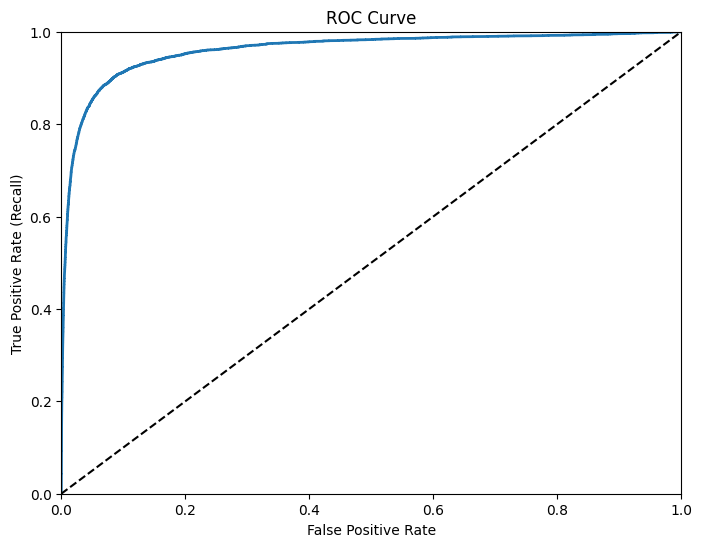

ROC AUC Score: 0.9605


In [2]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

# --- 3. Performance Measures ---

# Mendapatkan prediksi clean dari cross-validation
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# Confusion Matrix
cm = confusion_matrix(y_train_5, y_train_pred)
print("\nConfusion Matrix:")
print(cm)
print("(Baris: Kelas Asli, Kolom: Prediksi)")

# Precision, Recall, F1
print(f"Precision: {precision_score(y_train_5, y_train_pred):.4f}")
print(f"Recall   : {recall_score(y_train_5, y_train_pred):.4f}")
print(f"F1 Score : {f1_score(y_train_5, y_train_pred):.4f}")

# --- 4. Plotting Curves ---
# Mendapatkan decision scores (bukan prediksi label langsung)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Garis diagonal putus-putus
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve')

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

print(f"ROC AUC Score: {roc_auc_score(y_train_5, y_scores):.4f}")

In [ ]:
from sklearn.svm import SVC

# --- 5. Multiclass Classification ---
print("\n--- Multiclass Classification ---")
# Scikit-Learn otomatis mendeteksi multiclass dan menggunakan strategi OvO atau OvR
# Kita gunakan sebagian data saja agar training cepat (SVC lambat di data besar)
svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # Training pada 1000 data pertama
print("Training SVC selesai.")

# Prediksi digit
some_digit_scores = svm_clf.decision_function([some_digit])
print(f"Scores untuk 10 kelas:\n{some_digit_scores}")
print(f"Kelas prediksi: {np.argmax(some_digit_scores)}")

# --- 6. Error Analysis (Visualisasi Confusion Matrix) ---
# Kita gunakan SGDClassifier lagi untuk seluruh data (karena lebih cepat dari SVM)
sgd_clf.fit(X_train, y_train)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

# Normalisasi matrix untuk melihat error rate, bukan jumlah absolut
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# Isi diagonal dengan 0 agar fokus pada error (warna terang = banyak error)
np.fill_diagonal(norm_conf_mx, 0)

plt.figure(figsize=(8, 8))
plt.matshow(norm_conf_mx, cmap=plt.cm.gray, fignum=1)
plt.title("Confusion Matrix of Errors")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()
print("Analisis: Warna terang menunjukkan di mana model sering salah klasifikasi.")


--- Multiclass Classification ---
Training SVC selesai.
Scores untuk 10 kelas:
[[ 2.81585438  7.09167958  3.82972099  0.79365551  5.8885703   9.29718395
   1.79862509  8.10392157 -0.228207    4.83753243]]
Kelas prediksi: 5
